## Margin Density Drift Detection (MD3)

Concept drift can be seen as a change in the joint probability distribution of the data sample X and their corresponding classes - Y. If it were an entirely unlabeled change detection technique it will track changes in P(X) (example, KS tests), and if it were a labeled drift detection technique it will directly track P(Y|X) (example, tracking metrics like accuracy of the model). 

Today’s approach - margin density drift detection falls somewhat under the unsupervised category, that tracks changes to P(Y|X) without explicitly needing labeled samples.

In [1]:
import sys  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from matplotlib.pyplot import figure

sys.path.insert(0, './')
from plots import decision_regions

Using the popular Iris dataset for demo

In [2]:
iris = datasets.load_iris()
y = iris['target']
y = y[(y==0)|(y==1)]
#y = np.where(y == 1, 1, 0)
x = iris['data']
x = x[:len(y), :2]

print(f"x {x.shape}, y {y.shape}")
print("x and y values")
print(x[:5], y[:5])

x (100, 2), y (100,)
x and y values
[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]] [0 0 0 0 0]


In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=123, stratify=y)
x_test1, x_test2, y_test1, y_test2 = train_test_split(x_test, y_test, test_size=0.5, random_state=123, stratify=y_test)
print(f"train {x_train.shape}, test1 {x_test1.shape}, test2 {x_test2.shape}")

train (60, 2), test1 (20, 2), test2 (20, 2)


training a SVM model

In [4]:
svc = SVC(kernel='linear', C=10.0, random_state=123)
svc.fit(x_train, y_train)
print(f"len of support vectors {len(svc.support_)}")

len of support vectors 6


### Watch how the margin density changes from training data sample to the test data samples

The change could be more or less as new data samples become available

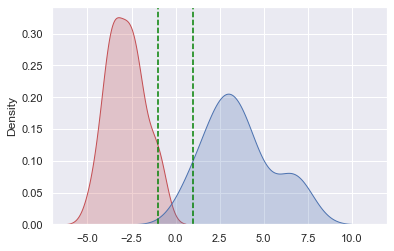

In [5]:
sns.set(style="darkgrid")
train_preds = svc.decision_function(x_train)
y_preds = svc.predict(x_train)
train_preds_0 = train_preds[y_preds == 0]
train_preds_1 = train_preds[y_preds == 1]

fig = sns.kdeplot(train_preds_0, shade=True, color="r", label="class A")
fig = sns.kdeplot(train_preds_1, shade=True, color="b", label="class B")
plt.xlim(-7, 12)
plt.axvline(-1.0, linestyle='--', color='green')
plt.axvline(1.0, linestyle='--', color='green')
plt.show()

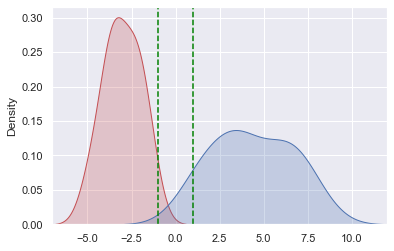

In [6]:
test1_preds = svc.decision_function(x_test1)
y_preds = svc.predict(x_test1)
test1_preds_0 = test1_preds[y_preds == 0]
test1_preds_1 = test1_preds[y_preds == 1]

fig = sns.kdeplot(test1_preds_0, shade=True, color="r")
fig = sns.kdeplot(test1_preds_1, shade=True, color="b")
plt.xlim(-7, 12)
plt.axvline(-1.0, linestyle='--', color='green')
plt.axvline(1.0, linestyle='--', color='green')
plt.show()

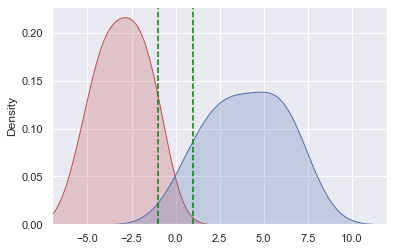

In [7]:
test2_preds = svc.decision_function(x_test2)
y_preds = svc.predict(x_test2)
test2_preds_0 = test2_preds[y_preds == 0]
test2_preds_1 = test2_preds[y_preds == 1]

fig = sns.kdeplot(test2_preds_0, shade=True, color="r")
fig = sns.kdeplot(test2_preds_1, shade=True, color="b")
plt.xlim(-7, 12)
plt.axvline(-1.0, linestyle='--', color='green')
plt.axvline(1.0, linestyle='--', color='green')
plt.show()

At a very high level the MD3 technique monitors the number of samples in the classifier’s region of uncertainty (that is, it’s margin) to detect drifts. The underlying assumption is that margin is crucial to a model’s generalization and any change to the margin density is worthy of further exploration. And since the margin density can be computed from unlabeled data only, it could be used as substitute to explicit labeled drift detection techniques for monitoring changes in P(Y|X)

In [8]:
preds = svc.decision_function(x_train)
support_vectors = [1 if abs(p) <= 1 else 0 for p in preds]
support_vector_idxs = [idx for idx, val in enumerate(support_vectors) if val == 1]
print(f"num of support vectors through signal function {sum(support_vectors)}")

num of support vectors through signal function 4


Now something like a Support Vector Machine (SVM) explicitly defines a margin. This is also true for logistic regression. But in addition, a soft-margin linear kernel SVM finds an optimal maximum width separating hyperplane between two classes, by allowing a few samples to enter the margin. This allows for better generalization and is made possible because of the slack variables in the optimization function. The samples in the margin area here are the support vectors.

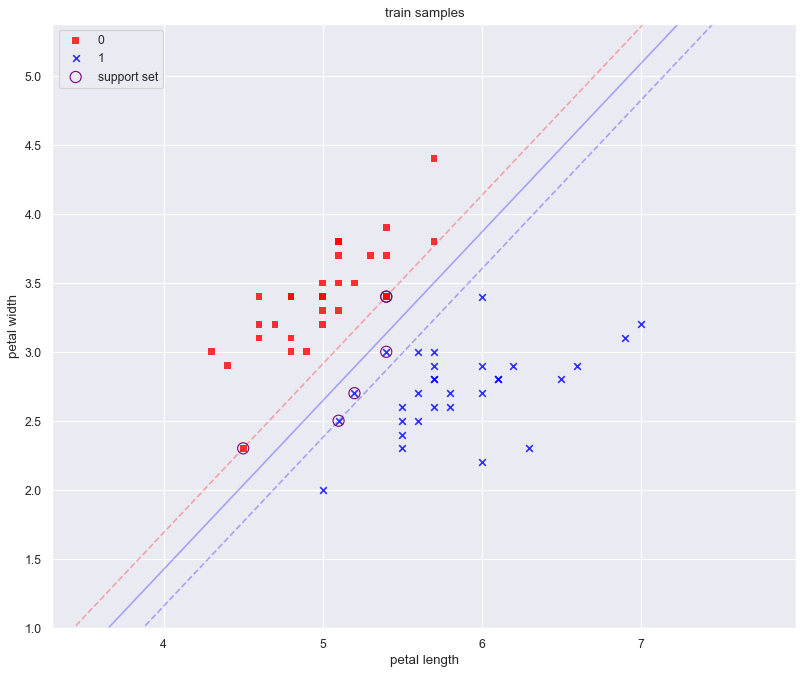

In [9]:
figure(figsize=(12, 10), dpi=80)
decision_regions(x_train, y_train, svc, plot_support=True, plot_custom_support=False)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')
plt.title('train samples')
plt.show()

So, our margin density in this case is given by the ratio of the number of support vectors and the total number of data points.

Now when we bring another set of new data points, we can see some increase in the density of the points in the margin region. Overtime, if there are any distributional changes we shall see the initial margin density change.

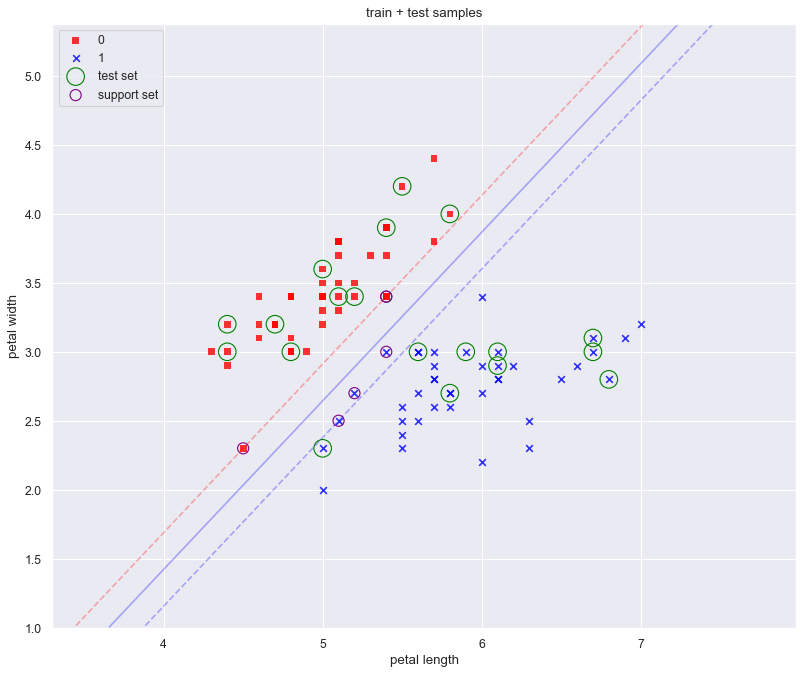

In [10]:
x_combined = np.vstack((x_train, x_test1))
y_combined = np.hstack((y_train, y_test1))
figure(figsize=(12, 10), dpi=80)
decision_regions(x_combined, y_combined, svc, test_idx=range(61, 80), plot_support=True, plot_custom_support=False)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')
plt.title('train + test samples')
plt.show()

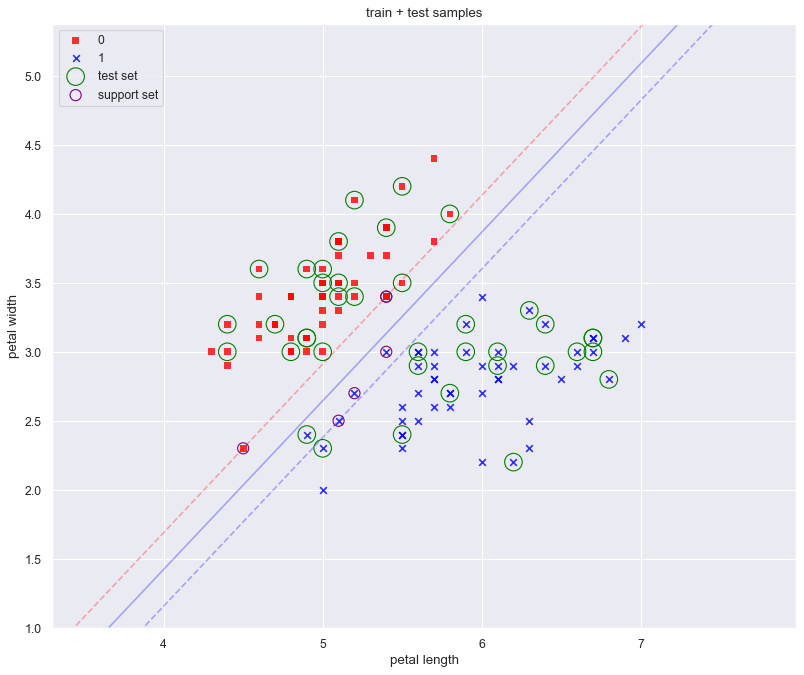

In [11]:
x_combined = np.vstack((x_train, x_test1, x_test2))
y_combined = np.hstack((y_train, y_test1, y_test2))
figure(figsize=(12, 10), dpi=80)
decision_regions(x_combined, y_combined, svc, test_idx=range(61, 100), plot_support=True, plot_custom_support=False)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')
plt.title('train + test samples')
plt.show()

### MD3 algorithm at a very high level:

- Train an initial model
- Calculate a reference margin density (using k-fold validation) and accuracy (or any other metric) based on this initial model
- Decide on the chunk size, that is, the number of datapoint in the window, typically set to the number of initial training data points
- As and when new data arrives 
    - Check if the new sample is part of the margin 
    - monitor the reference margin density, if it has changed drastically (based on some std dev measure), collect a label for this sample
    - If there is a drift and the number of data points that have drifted (and have labels) is equal to the chunk size, 
        - And the accuracy metric with the current model has declined, then
            - retrain the model and update the reference margin density and accuracy metric
- Repeat this process for the next set of data points


### Pros
- Not an overly reactive system in the sense that you don’t have to re-train every time you get new data, there by helping with excessive amount of labeling and even some kind of manipulation by an adversary
- Classifier independent, unlabeled and incremental approach to reliably signal concept drift from streaming data


### Cons
- Dependent on the robustness of the initial model
